<a href="https://colab.research.google.com/github/hee-chang/Final_Project/blob/main/GAN_project(Used_dataset_%3D_Celeb_a%2C_image_size_%3D_128).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN

## Import Library

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import time

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, LeakyReLU, Layer, Conv2D, BatchNormalization, Flatten, Conv2DTranspose
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

## Upload datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Colab_Notebooks/final_project/img_align_celeba.zip

## Generator

In [ ]:
class Generator(Model):
    def __init__(self):
        super().__init__()
        self.dense = Dense(8*8*128, use_bias=False, input_shape=(100,))
        self.bn = BatchNormalization()
        self.lrelu = LeakyReLU()
        
        self.deconv1 = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)
        self.bn1 = BatchNormalization()
        self.lrelu1 = LeakyReLU()
        
        self.deconv2 = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)
        self.bn2 = BatchNormalization()
        self.lrelu2 = LeakyReLU()
        
        self.deconv3 = Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same')

    def call(self, x, training=None, mask=None):
        h = self.lrelu(self.bn(self.dense(x), training))
        h = tf.reshape(h, (-1, 8, 8, 128))
        h = self.lrelu1(self.bn1(self.deconv1(h), training))
        h = self.lrelu2(self.bn2(self.deconv2(h), training))
        return self.deconv3(h)

## Discriminator

In [ ]:
class Discriminator(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(64, (5, 5), strides=(2, 2), padding='same')
        self.bn1 = BatchNormalization()
        self.lrelu1 = LeakyReLU()
        
        self.conv2 = Conv2D(128, (5, 5), strides=(2, 2), padding='same')
        self.bn2 = BatchNormalization()
        self.lrelu2 = LeakyReLU()
        
        self.flatten = Flatten()
        self.dense = Dense(1, activation='sigmoid')

    def call(self, x, training=None, mask=None):
        h = self.lrelu1(self.bn1(self.conv1(x), training))
        h = self.lrelu2(self.bn2(self.conv2(h), training))
        return self.dense(self.flatten(h))

## Datasets Preprocessing

In [ ]:
def get_data():
    data = []
    count = 0
    for i in range(1, 202600):
        image = load_img('/content/img_align_celeba/' + str('{:06d}'.format(i)) + '.jpg',
                         target_size=(32, 32))
        image = img_to_array(image, dtype = 'float32')/255.0
        data.append(image)
        count += 1
    return(data)

dataset = get_data()
dataset = tf.data.Dataset.from_tensor_slices(dataset).batch(32)

In [ ]:
dataset

<BatchDataset shapes: (None, 32, 32, 3), types: tf.float32>

## Dataset Images

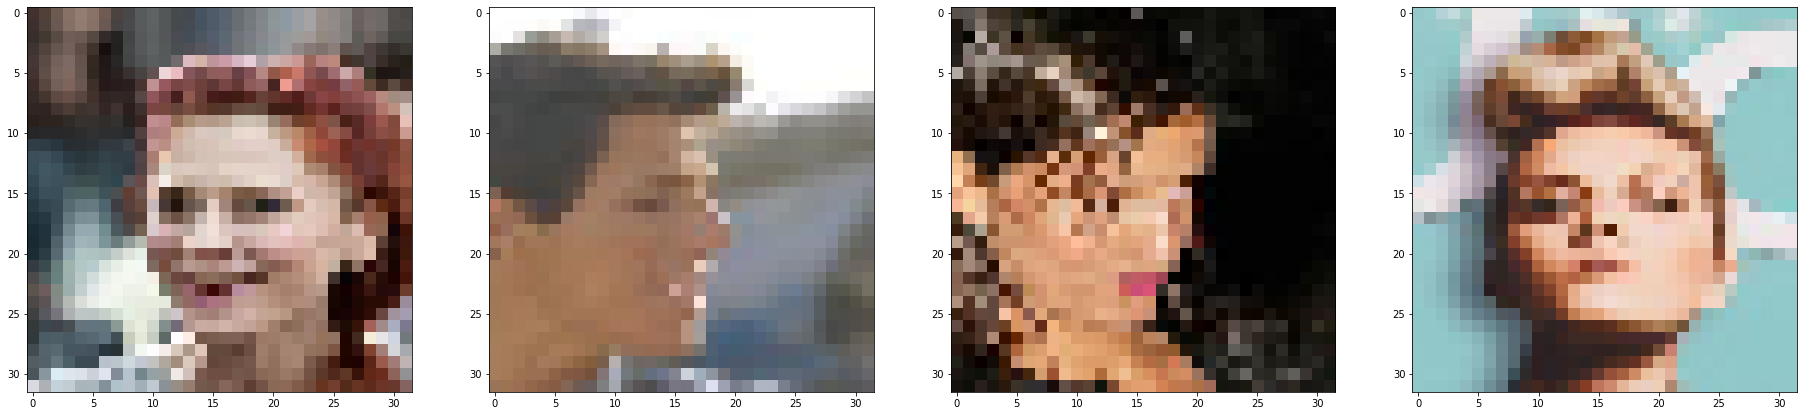

In [ ]:
fig = plt.figure(figsize=(40,10))
for i in dataset:
    m = i
    break
nplot = 5
for count in range(1,nplot):
    ax = fig.add_subplot(1,nplot,count)
    ax.imshow(m[count])
plt.show()

## Model, Optimizers

In [ ]:
generator = Generator()
discriminator = Discriminator()

optim_d = tf.optimizers.Adam(1e-4)
optim_g = tf.optimizers.Adam(1e-4)

d_mean = tf.metrics.Mean()
g_mean = tf.metrics.Mean()

## Losses

In [ ]:
def discriminator_loss(d_real, d_fake):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(d_real), d_real)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(d_fake), d_fake)
    return real_loss + fake_loss

def generator_loss(d_fake):
    return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(d_fake), d_fake)

## Training Step

In [ ]:
@tf.function
def train_step(image, optim_d, optim_g):
    with tf.GradientTape() as tape_d, tf.GradientTape() as tape_g: 
        z = tf.random.normal([32, 100])
        g = generator(z, training=True)
        
        d_real = discriminator(image, training=True)
        d_fake = discriminator(g, training=True)

        d_loss = discriminator_loss(d_real, d_fake)
        g_loss = generator_loss(d_fake)
        
        gradients_d = tape_d.gradient(d_loss, discriminator.trainable_weights)
        gradients_g = tape_g.gradient(g_loss, generator.trainable_weights)
    
    optim_d.apply_gradients(zip(gradients_d, discriminator.trainable_weights))
    optim_g.apply_gradients(zip(gradients_g, generator.trainable_weights))
    return d_loss, g_loss

## Training Loop

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1, d_loss: 0.248198002576828, g_loss: 3.5398333072662354


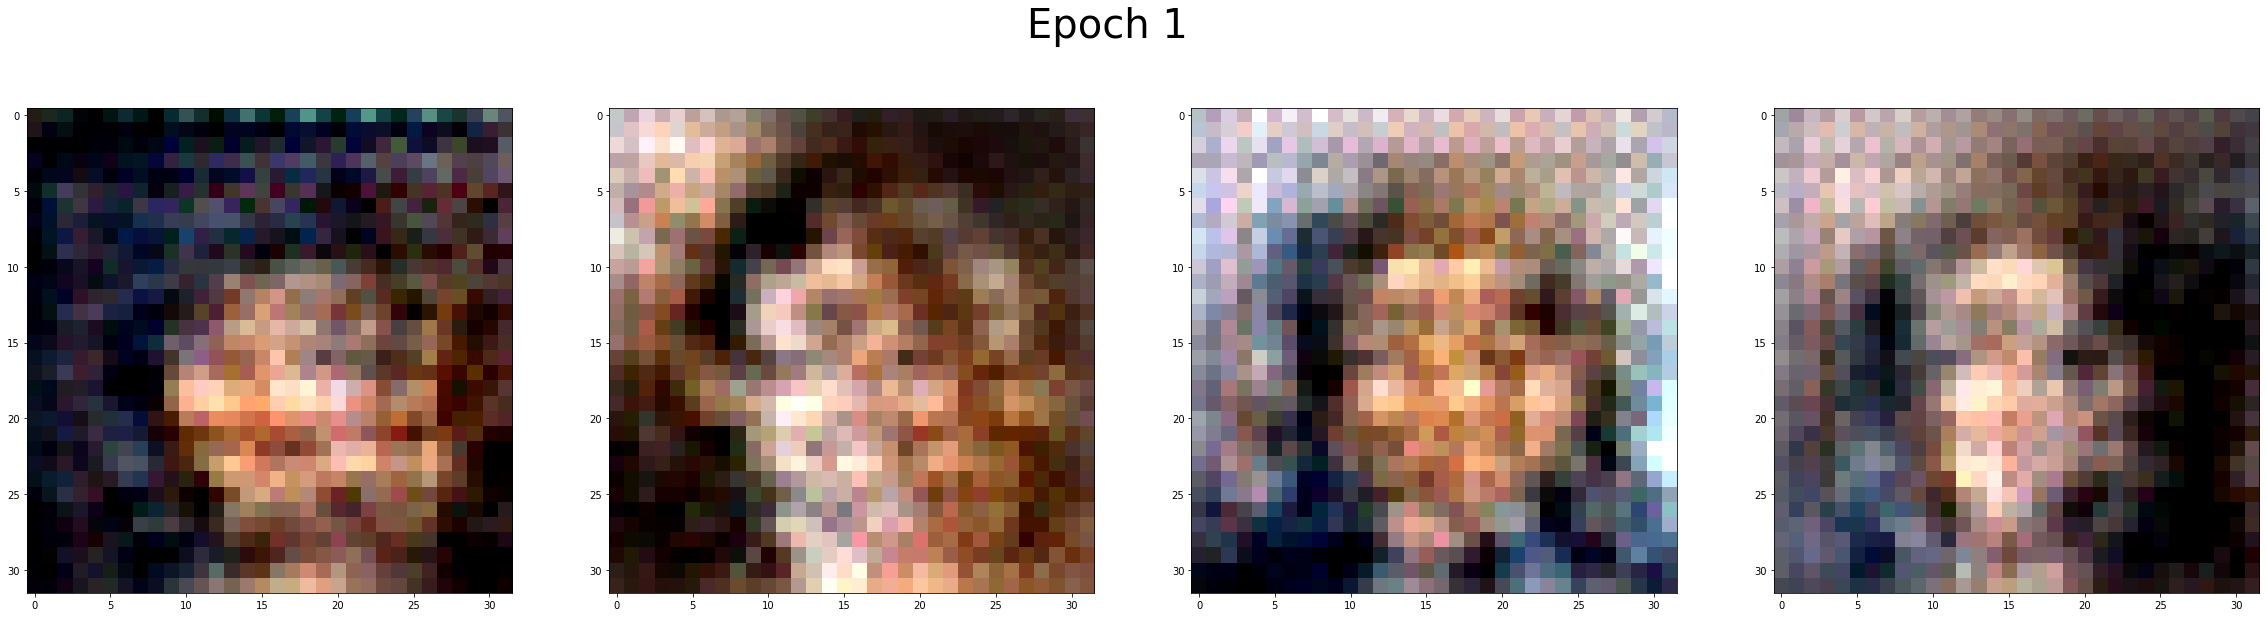

epoch: 2, d_loss: 0.44832274317741394, g_loss: 2.349153518676758
epoch: 3, d_loss: 0.30921003222465515, g_loss: 2.930217981338501
epoch: 4, d_loss: 0.2359001785516739, g_loss: 3.372011184692383
epoch: 5, d_loss: 0.20302793383598328, g_loss: 3.694607734680176
epoch: 6, d_loss: 0.18593207001686096, g_loss: 3.9543862342834473
epoch: 7, d_loss: 0.18204639852046967, g_loss: 4.032863616943359
epoch: 8, d_loss: 0.16432654857635498, g_loss: 4.23082971572876
epoch: 9, d_loss: 0.1466623693704605, g_loss: 4.5412373542785645
epoch: 10, d_loss: 0.14994511008262634, g_loss: 4.5789055824279785
epoch: 11, d_loss: 0.13075563311576843, g_loss: 4.845333099365234
epoch: 12, d_loss: 0.1270003765821457, g_loss: 4.926029682159424
epoch: 13, d_loss: 0.11084680259227753, g_loss: 5.0790228843688965
epoch: 14, d_loss: 0.10873831063508987, g_loss: 5.317497730255127
epoch: 15, d_loss: 0.10131285339593887, g_loss: 5.417147159576416
epoch: 16, d_loss: 0.09672433882951736, g_loss: 5.4017558097839355
epoch: 17, d_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 31, d_loss: 0.06631603837013245, g_loss: 6.592550754547119


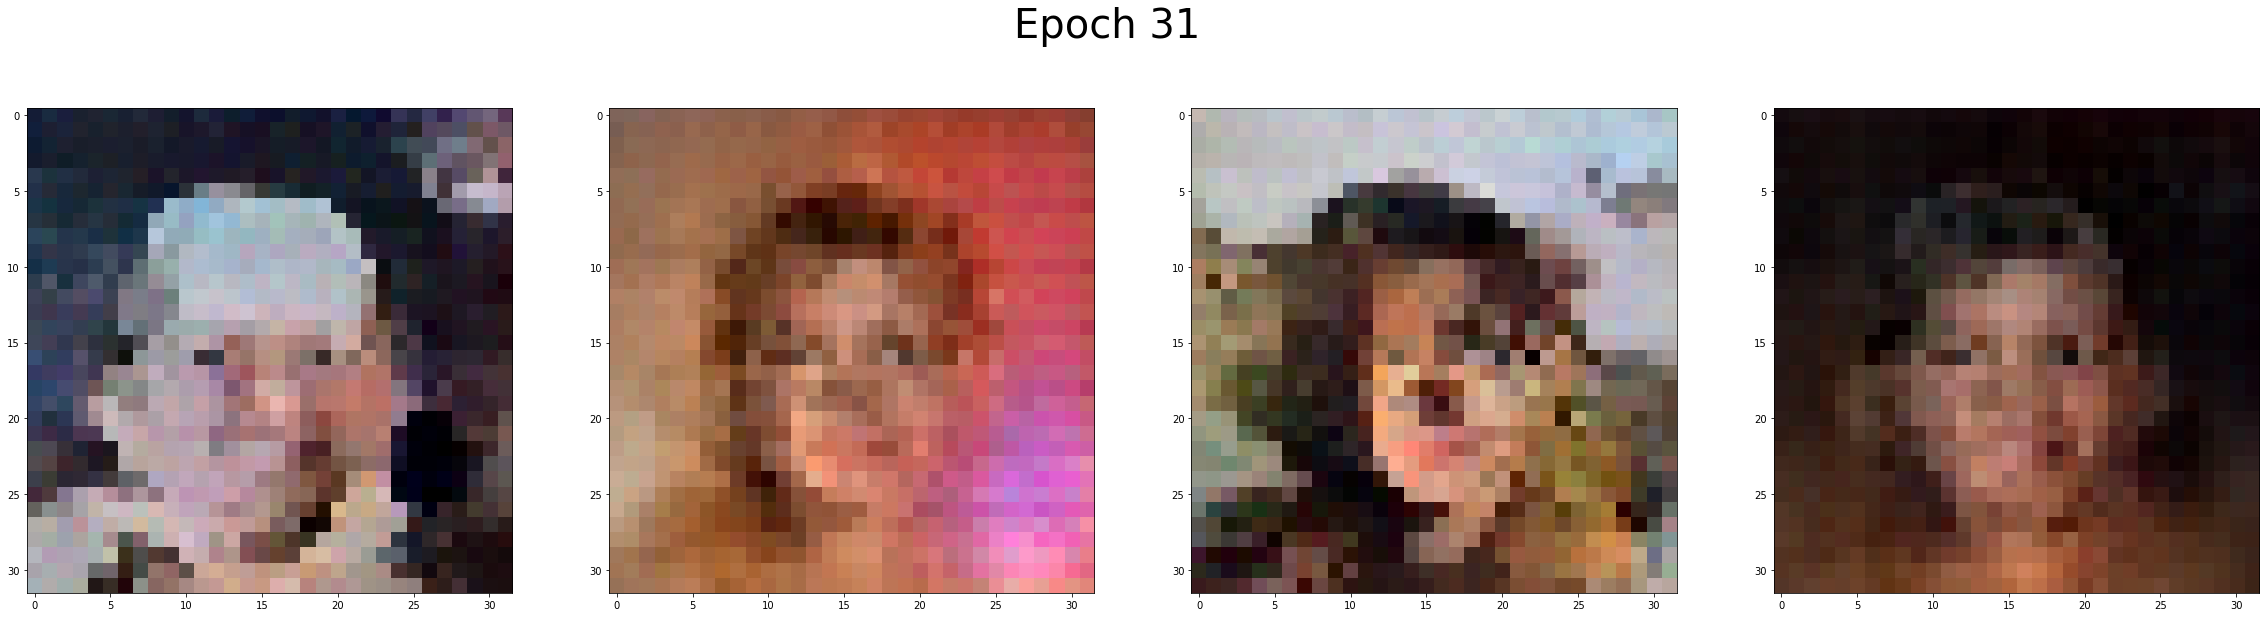

epoch: 32, d_loss: 0.06875834614038467, g_loss: 6.484406471252441
epoch: 33, d_loss: 0.05831877887248993, g_loss: 6.815999507904053
epoch: 34, d_loss: 0.06575293838977814, g_loss: 6.719837188720703
epoch: 35, d_loss: 0.0679376870393753, g_loss: 6.677918910980225
epoch: 36, d_loss: 0.0654454231262207, g_loss: 6.762864112854004
epoch: 37, d_loss: 0.06775427609682083, g_loss: 6.742030620574951
epoch: 38, d_loss: 0.07639721035957336, g_loss: 6.669560432434082
epoch: 39, d_loss: 0.07191086560487747, g_loss: 6.9589338302612305
epoch: 40, d_loss: 0.08024429529905319, g_loss: 6.698431015014648
epoch: 41, d_loss: 0.06907349079847336, g_loss: 6.784702777862549
epoch: 42, d_loss: 0.06540828943252563, g_loss: 6.958245754241943
epoch: 43, d_loss: 0.05427226796746254, g_loss: 7.8072428703308105
epoch: 44, d_loss: 0.0681791827082634, g_loss: 6.859346389770508
epoch: 45, d_loss: 0.06646547466516495, g_loss: 6.951687812805176
epoch: 46, d_loss: 0.07167688757181168, g_loss: 7.043822765350342
epoch: 47, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 61, d_loss: 0.0690000131726265, g_loss: 7.185099124908447


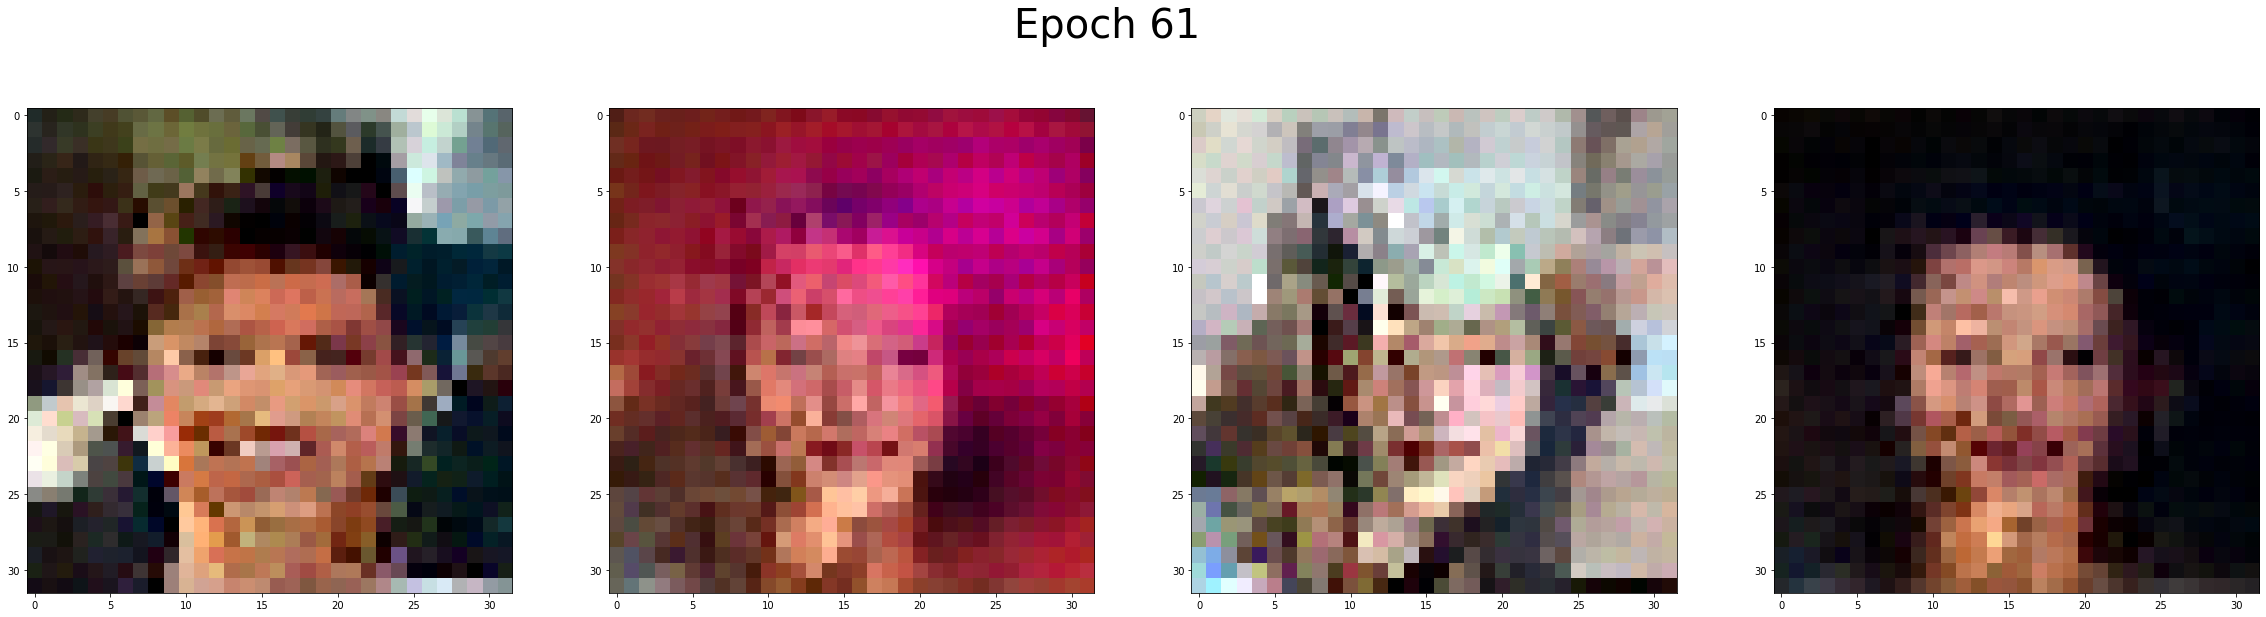

epoch: 62, d_loss: 0.08634315431118011, g_loss: 7.245386600494385
epoch: 63, d_loss: 0.08574404567480087, g_loss: 6.851568222045898
epoch: 64, d_loss: 0.08188870549201965, g_loss: 7.057596206665039
epoch: 65, d_loss: 0.07510463893413544, g_loss: 6.978224277496338
epoch: 66, d_loss: 0.08083856850862503, g_loss: 7.379044055938721
epoch: 67, d_loss: 0.07324519753456116, g_loss: 7.213550567626953
epoch: 68, d_loss: 0.07228022813796997, g_loss: 7.423670291900635
epoch: 69, d_loss: 0.05121881887316704, g_loss: 8.476207733154297
epoch: 70, d_loss: 0.06390266120433807, g_loss: 7.3524065017700195
epoch: 71, d_loss: 0.07522732764482498, g_loss: 7.443203449249268
epoch: 72, d_loss: 0.08373703062534332, g_loss: 7.197490215301514
epoch: 73, d_loss: 0.07905466109514236, g_loss: 7.013375759124756
epoch: 74, d_loss: 0.07795216888189316, g_loss: 7.038450717926025
epoch: 75, d_loss: 0.0837298259139061, g_loss: 7.025245666503906
epoch: 76, d_loss: 0.08784704655408859, g_loss: 7.265096187591553
epoch: 77,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 91, d_loss: 0.08775917440652847, g_loss: 7.411386966705322


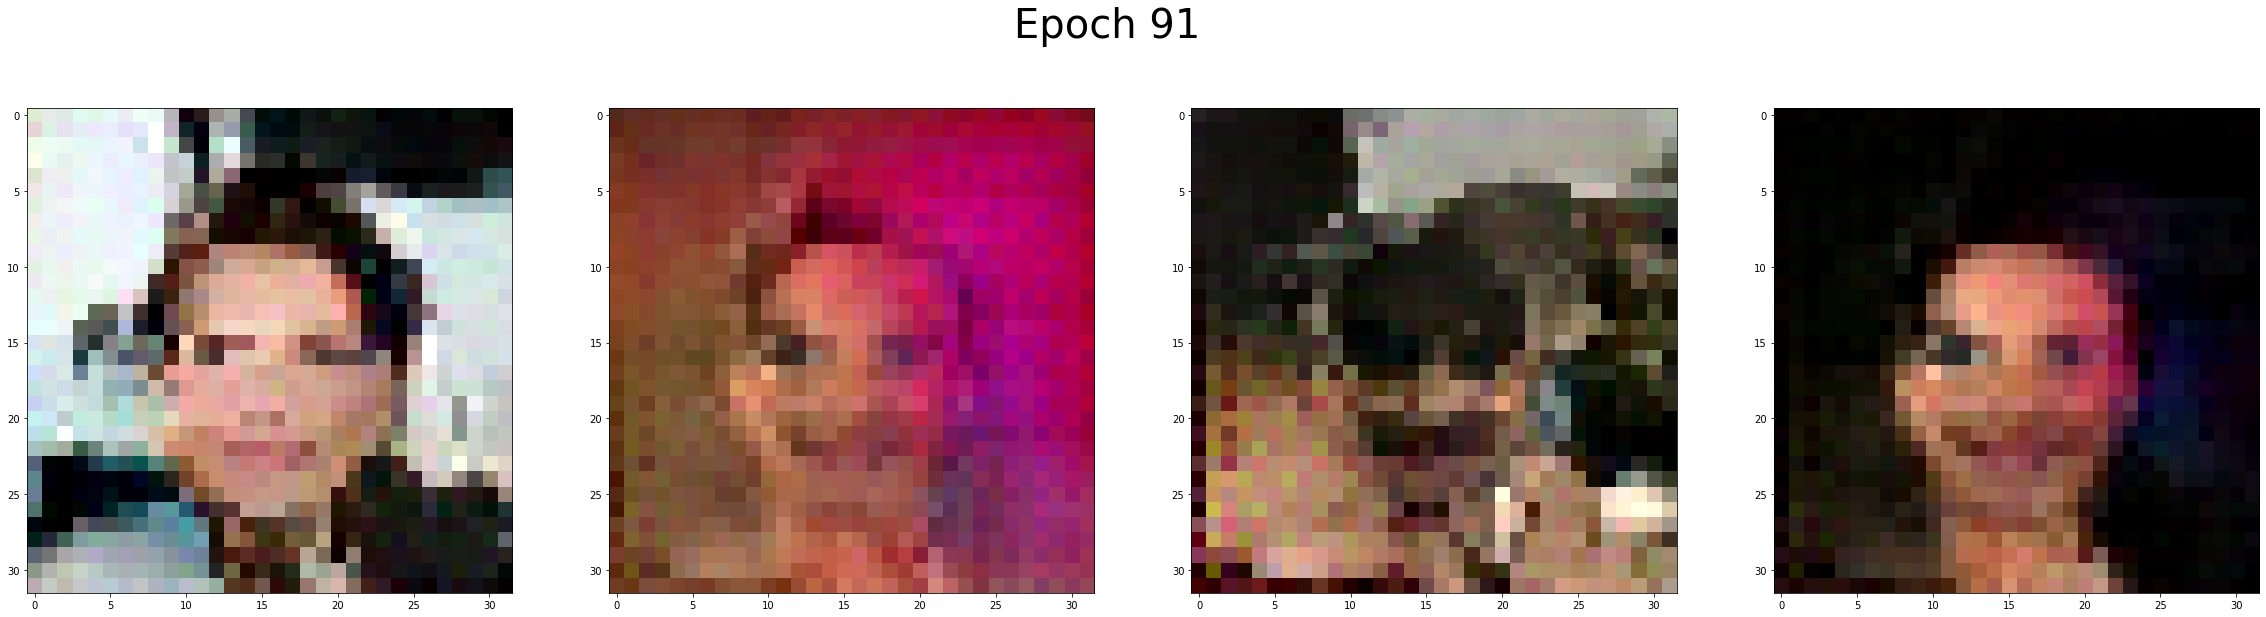

epoch: 92, d_loss: 0.0849708765745163, g_loss: 7.286550998687744
epoch: 93, d_loss: 0.09982041269540787, g_loss: 7.2684006690979
epoch: 94, d_loss: 0.08714671432971954, g_loss: 7.184603214263916
epoch: 95, d_loss: 0.09544553607702255, g_loss: 7.2400383949279785
epoch: 96, d_loss: 0.09832623600959778, g_loss: 6.969254493713379
epoch: 97, d_loss: 0.09159563481807709, g_loss: 7.233424186706543
epoch: 98, d_loss: 0.08643566817045212, g_loss: 7.55055046081543
epoch: 99, d_loss: 0.10055959969758987, g_loss: 7.213440895080566
epoch: 100, d_loss: 0.0932152196764946, g_loss: 7.182044506072998
epoch: 101, d_loss: 0.08592462539672852, g_loss: 7.104840278625488
epoch: 102, d_loss: 0.08857160061597824, g_loss: 7.314277172088623
epoch: 103, d_loss: 0.08817992359399796, g_loss: 7.043580055236816
epoch: 104, d_loss: 0.08468598872423172, g_loss: 7.3491291999816895
epoch: 105, d_loss: 0.08662254363298416, g_loss: 7.274019718170166
epoch: 106, d_loss: 0.08861243724822998, g_loss: 7.401008605957031
epoch:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 121, d_loss: 0.08575128018856049, g_loss: 7.428550720214844


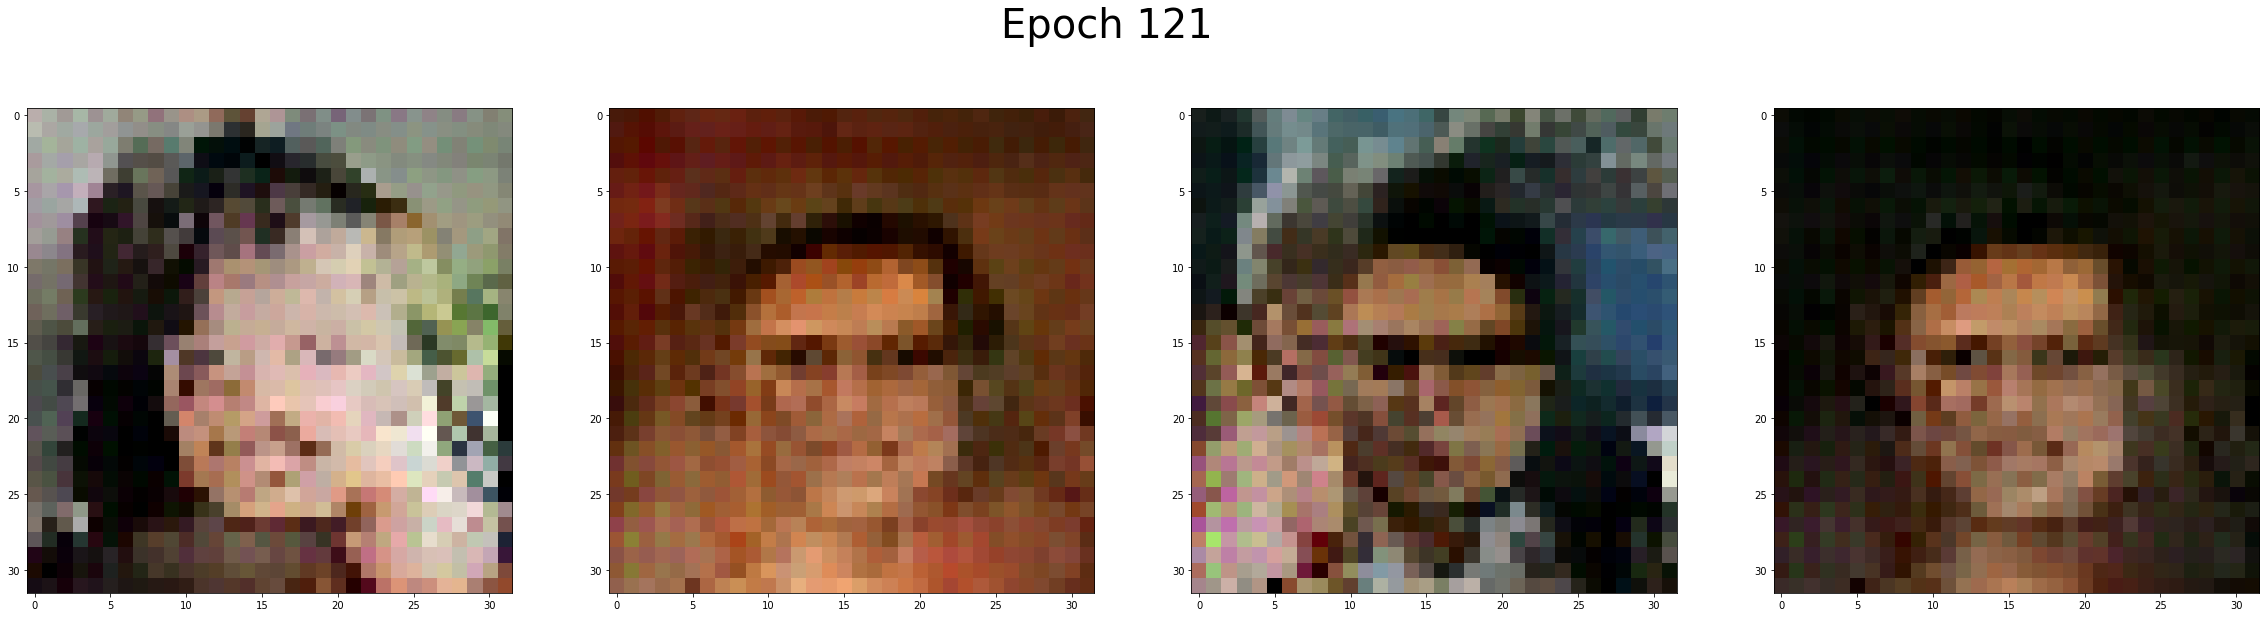

epoch: 122, d_loss: 0.09266968816518784, g_loss: 7.59304666519165
epoch: 123, d_loss: 0.1165289357304573, g_loss: 6.960055828094482
epoch: 124, d_loss: 0.11114621162414551, g_loss: 7.015657901763916
epoch: 125, d_loss: 0.09197121858596802, g_loss: 7.109331130981445
epoch: 126, d_loss: 0.09222917258739471, g_loss: 7.29847526550293
epoch: 127, d_loss: 0.09133925288915634, g_loss: 7.176340579986572
epoch: 128, d_loss: 0.09719537198543549, g_loss: 7.384914398193359
epoch: 129, d_loss: 0.10898830741643906, g_loss: 7.080570220947266
epoch: 130, d_loss: 0.10638552159070969, g_loss: 7.09882116317749
epoch: 131, d_loss: 0.09822725504636765, g_loss: 7.129544734954834
epoch: 132, d_loss: 0.11120977252721786, g_loss: 7.075345993041992
epoch: 133, d_loss: 0.10199859738349915, g_loss: 7.177530288696289
epoch: 134, d_loss: 0.10385020077228546, g_loss: 7.088419437408447
epoch: 135, d_loss: 0.08717770129442215, g_loss: 7.304903984069824
epoch: 136, d_loss: 0.08894942700862885, g_loss: 7.112728118896484

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 151, d_loss: 0.10219001770019531, g_loss: 7.354824066162109


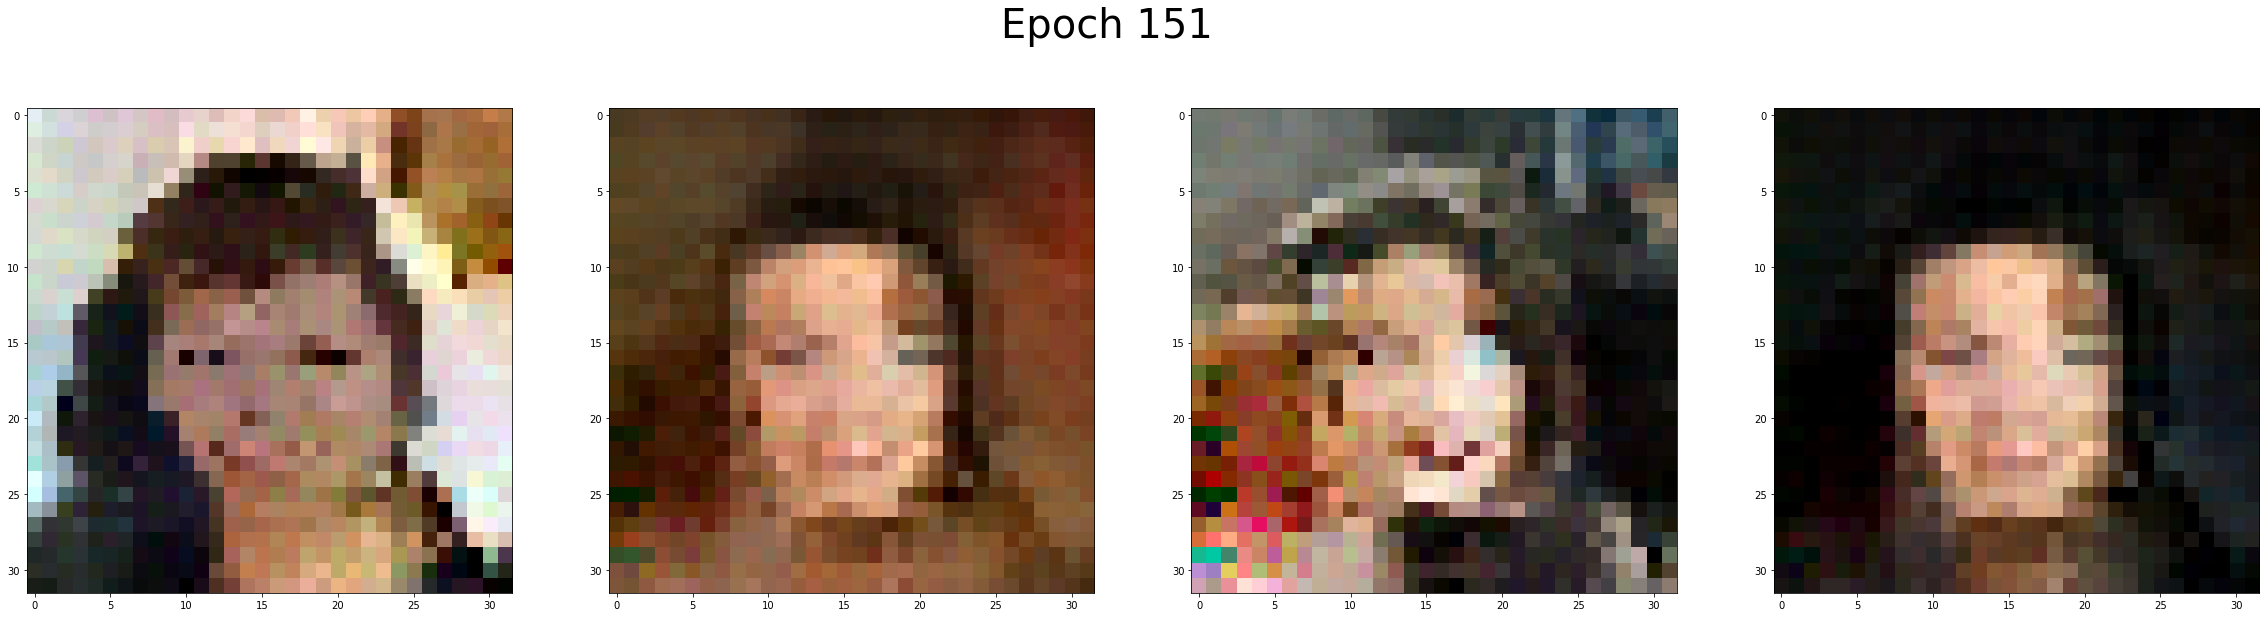

epoch: 152, d_loss: 0.10733639448881149, g_loss: 7.094796180725098
epoch: 153, d_loss: 0.09334349632263184, g_loss: 7.360925197601318
epoch: 154, d_loss: 0.09552660584449768, g_loss: 7.317882061004639
epoch: 155, d_loss: 0.0914822593331337, g_loss: 7.370472431182861
epoch: 156, d_loss: 0.1141585111618042, g_loss: 7.230595111846924
epoch: 157, d_loss: 0.11726291477680206, g_loss: 7.012763977050781
epoch: 158, d_loss: 0.10695160925388336, g_loss: 6.999279022216797
epoch: 159, d_loss: 0.10015843063592911, g_loss: 7.121011734008789
epoch: 160, d_loss: 0.10207000374794006, g_loss: 7.045498847961426
epoch: 161, d_loss: 0.10284349322319031, g_loss: 7.33394718170166
epoch: 162, d_loss: 0.11564687639474869, g_loss: 6.945050239562988
epoch: 163, d_loss: 0.10241416841745377, g_loss: 7.083001613616943
epoch: 164, d_loss: 0.09746457636356354, g_loss: 7.213008403778076
epoch: 165, d_loss: 0.10311488062143326, g_loss: 7.422975063323975
epoch: 166, d_loss: 0.10774979740381241, g_loss: 7.03010511398315

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 181, d_loss: 0.10759546607732773, g_loss: 6.894004821777344


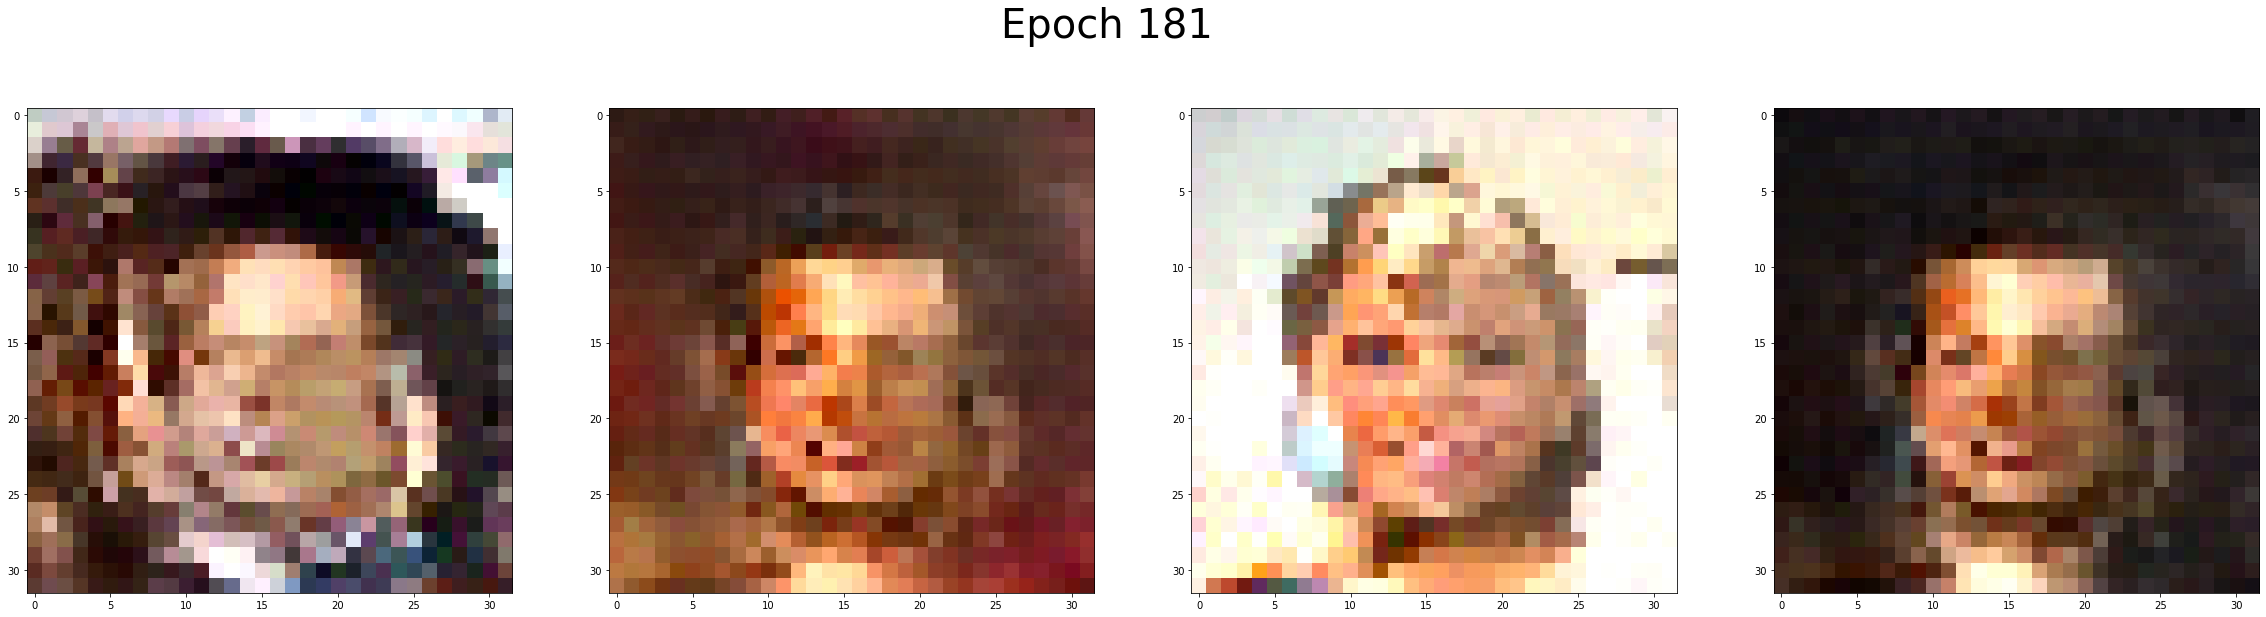

epoch: 182, d_loss: 0.11465322971343994, g_loss: 6.759109020233154
epoch: 183, d_loss: 0.1009390652179718, g_loss: 6.955970764160156
epoch: 184, d_loss: 0.10715056955814362, g_loss: 6.980263710021973
epoch: 185, d_loss: 0.11845603585243225, g_loss: 7.025416374206543
epoch: 186, d_loss: 0.10640940070152283, g_loss: 7.037197113037109
epoch: 187, d_loss: 0.11251474171876907, g_loss: 7.276641845703125
epoch: 188, d_loss: 0.1336999088525772, g_loss: 7.142238616943359
epoch: 189, d_loss: 0.13289432227611542, g_loss: 6.7703351974487305
epoch: 190, d_loss: 0.12854129076004028, g_loss: 6.862270355224609
epoch: 191, d_loss: 0.1324639618396759, g_loss: 6.738707542419434
epoch: 192, d_loss: 0.13794656097888947, g_loss: 6.597405910491943
epoch: 193, d_loss: 0.13523007929325104, g_loss: 7.019615173339844
epoch: 194, d_loss: 0.13671794533729553, g_loss: 6.747183322906494
epoch: 195, d_loss: 0.12463808059692383, g_loss: 6.5754499435424805
epoch: 196, d_loss: 0.1116807758808136, g_loss: 7.0158009529113

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 211, d_loss: 0.12894654273986816, g_loss: 6.752144813537598


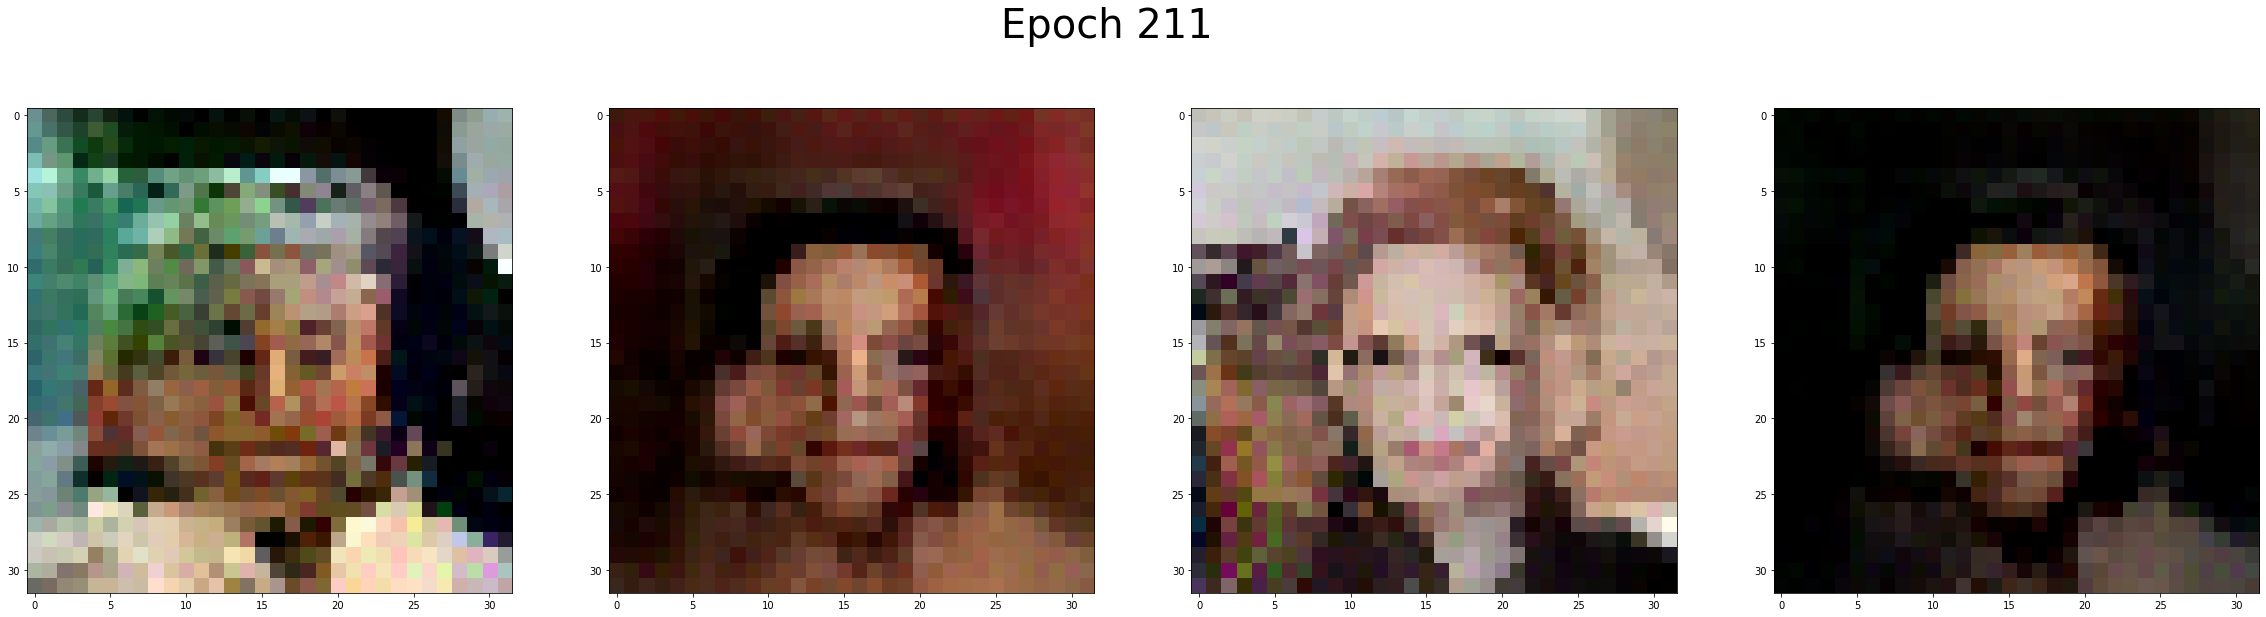

epoch: 212, d_loss: 0.12582242488861084, g_loss: 6.62471866607666
epoch: 213, d_loss: 0.14089345932006836, g_loss: 6.782168388366699
epoch: 214, d_loss: 0.13512466847896576, g_loss: 6.711430549621582
epoch: 215, d_loss: 0.12070273607969284, g_loss: 6.956429958343506
epoch: 216, d_loss: 0.14035475254058838, g_loss: 6.7067646980285645
epoch: 217, d_loss: 0.12856851518154144, g_loss: 6.741241931915283
epoch: 218, d_loss: 0.14290596544742584, g_loss: 6.745407581329346
epoch: 219, d_loss: 0.1315026432275772, g_loss: 6.816107749938965
epoch: 220, d_loss: 0.11773764342069626, g_loss: 7.048675060272217
epoch: 221, d_loss: 0.1275753676891327, g_loss: 6.9872727394104
epoch: 222, d_loss: 0.14044369757175446, g_loss: 6.755746364593506
epoch: 223, d_loss: 0.12741290032863617, g_loss: 6.750480651855469
epoch: 224, d_loss: 0.1386997252702713, g_loss: 7.02144718170166
epoch: 225, d_loss: 0.14226648211479187, g_loss: 6.798869609832764
epoch: 226, d_loss: 0.15386895835399628, g_loss: 6.375339984893799
e

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 241, d_loss: 0.14828082919120789, g_loss: 6.574441432952881


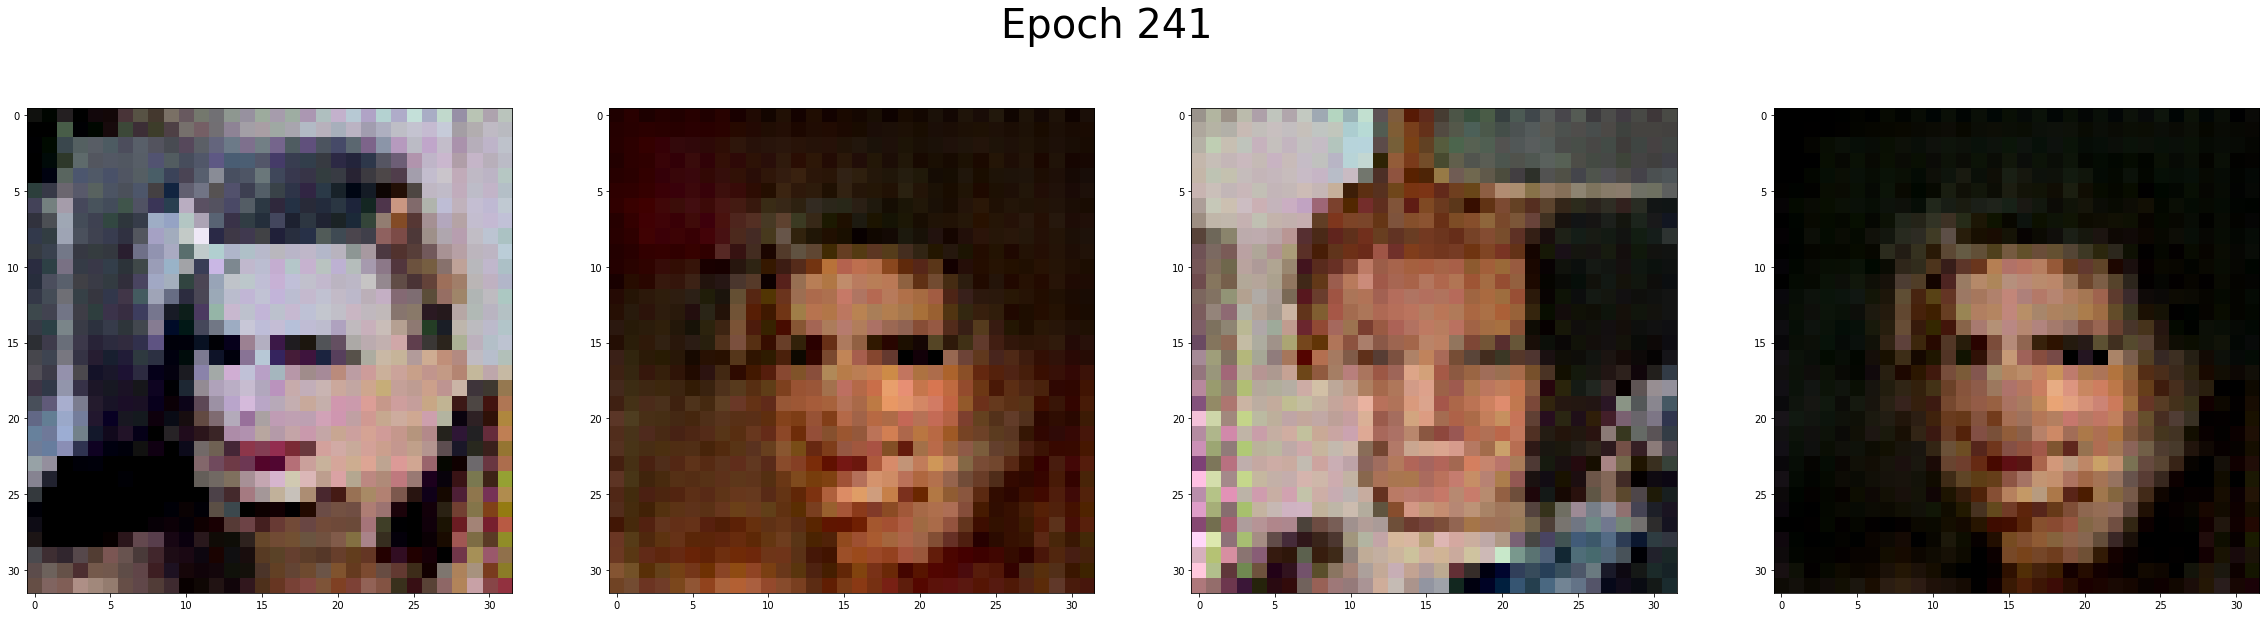

epoch: 242, d_loss: 0.15832921862602234, g_loss: 6.219778537750244
epoch: 243, d_loss: 0.1589040458202362, g_loss: 6.3333420753479
epoch: 244, d_loss: 0.16247114539146423, g_loss: 6.374075412750244
epoch: 245, d_loss: 0.14619894325733185, g_loss: 6.354578971862793
epoch: 246, d_loss: 0.14587917923927307, g_loss: 6.858400821685791
epoch: 247, d_loss: 0.1563195139169693, g_loss: 6.135854244232178
epoch: 248, d_loss: 0.14371392130851746, g_loss: 6.679013252258301
epoch: 249, d_loss: 0.15189023315906525, g_loss: 6.609115123748779
epoch: 250, d_loss: 0.15529170632362366, g_loss: 6.418026924133301
epoch: 251, d_loss: 0.17516553401947021, g_loss: 6.444268226623535
epoch: 252, d_loss: 0.16389144957065582, g_loss: 6.35953950881958
epoch: 253, d_loss: 0.16208115220069885, g_loss: 6.460543155670166
epoch: 254, d_loss: 0.15457522869110107, g_loss: 6.492189884185791
epoch: 255, d_loss: 0.16850371658802032, g_loss: 6.312245845794678
epoch: 256, d_loss: 0.1428823173046112, g_loss: 6.3374433517456055


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 271, d_loss: 0.16028574109077454, g_loss: 6.168365478515625


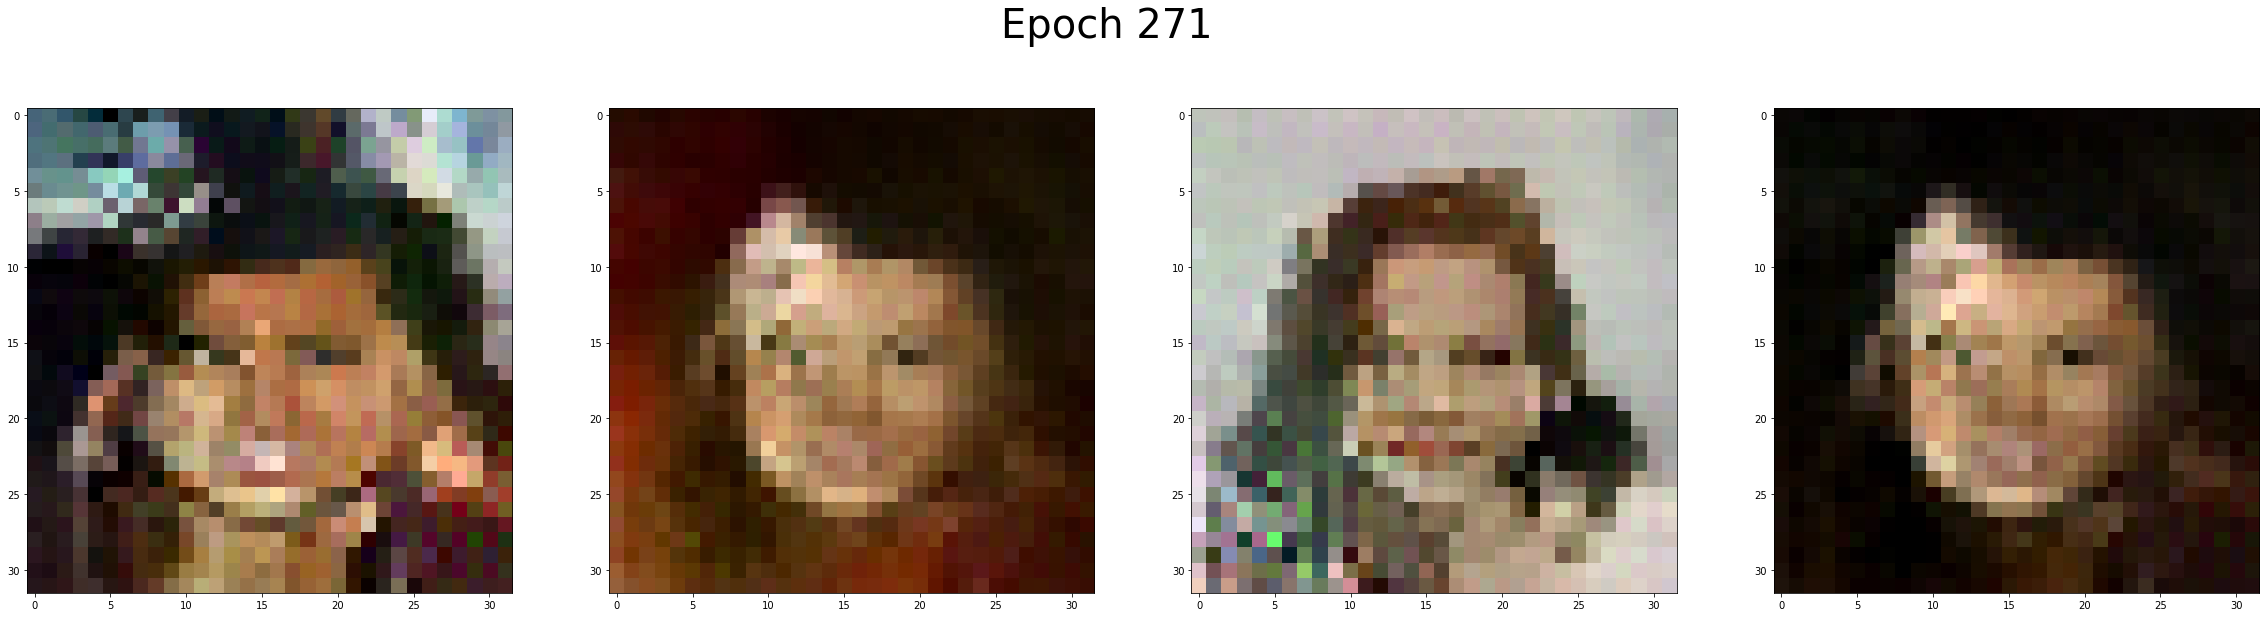

epoch: 272, d_loss: 0.17490403354167938, g_loss: 6.17651891708374
epoch: 273, d_loss: 0.16665878891944885, g_loss: 6.304667949676514
epoch: 274, d_loss: 0.16572627425193787, g_loss: 6.315752983093262
epoch: 275, d_loss: 0.18271128833293915, g_loss: 6.378471851348877
epoch: 276, d_loss: 0.16571404039859772, g_loss: 6.246802806854248
epoch: 277, d_loss: 0.18421442806720734, g_loss: 6.125097274780273
epoch: 278, d_loss: 0.16337083280086517, g_loss: 6.308498859405518
epoch: 279, d_loss: 0.16404974460601807, g_loss: 6.282747745513916
epoch: 280, d_loss: 0.1776007115840912, g_loss: 6.313821315765381
epoch: 281, d_loss: 0.15040960907936096, g_loss: 6.551474571228027
epoch: 282, d_loss: 0.14172153174877167, g_loss: 6.827331066131592
epoch: 283, d_loss: 0.13871370255947113, g_loss: 6.64254093170166
epoch: 284, d_loss: 0.1612827032804489, g_loss: 6.297885417938232
epoch: 285, d_loss: 0.18414676189422607, g_loss: 6.414284706115723
epoch: 286, d_loss: 0.15941880643367767, g_loss: 6.449102878570557

In [ ]:
d_loss_history = []
g_loss_history = []
sample_z = tf.random.normal([4, 100])
start = time.time()

def plot_images(sample_z, title=""):
    sample_img = generator(sample_z)
    fig = plt.figure(figsize=(40,10))
    for i, img in enumerate(sample_img):
        ax = fig.add_subplot(1,4,i+1)
        ax.imshow(img)
    fig.suptitle(title, fontsize=40)
    plt.show()


for epoch in range(300):
    for image in dataset:
        d_loss, g_loss = train_step(image, optim_d, optim_g)

        d_mean.update_state(d_loss)
        g_mean.update_state(g_loss)

    print('epoch: {}, d_loss: {}, g_loss: {}'.format(epoch+1, d_mean.result(), g_mean.result()))
    
    if epoch % 30 == 0:
        plot_images(sample_z, title="Epoch {}".format(epoch+1))

    d_loss_history.append(d_mean.result())
    g_loss_history.append(g_mean.result())

    d_mean.reset_states()
    g_mean.reset_states()

print("time :", time.time() - start)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


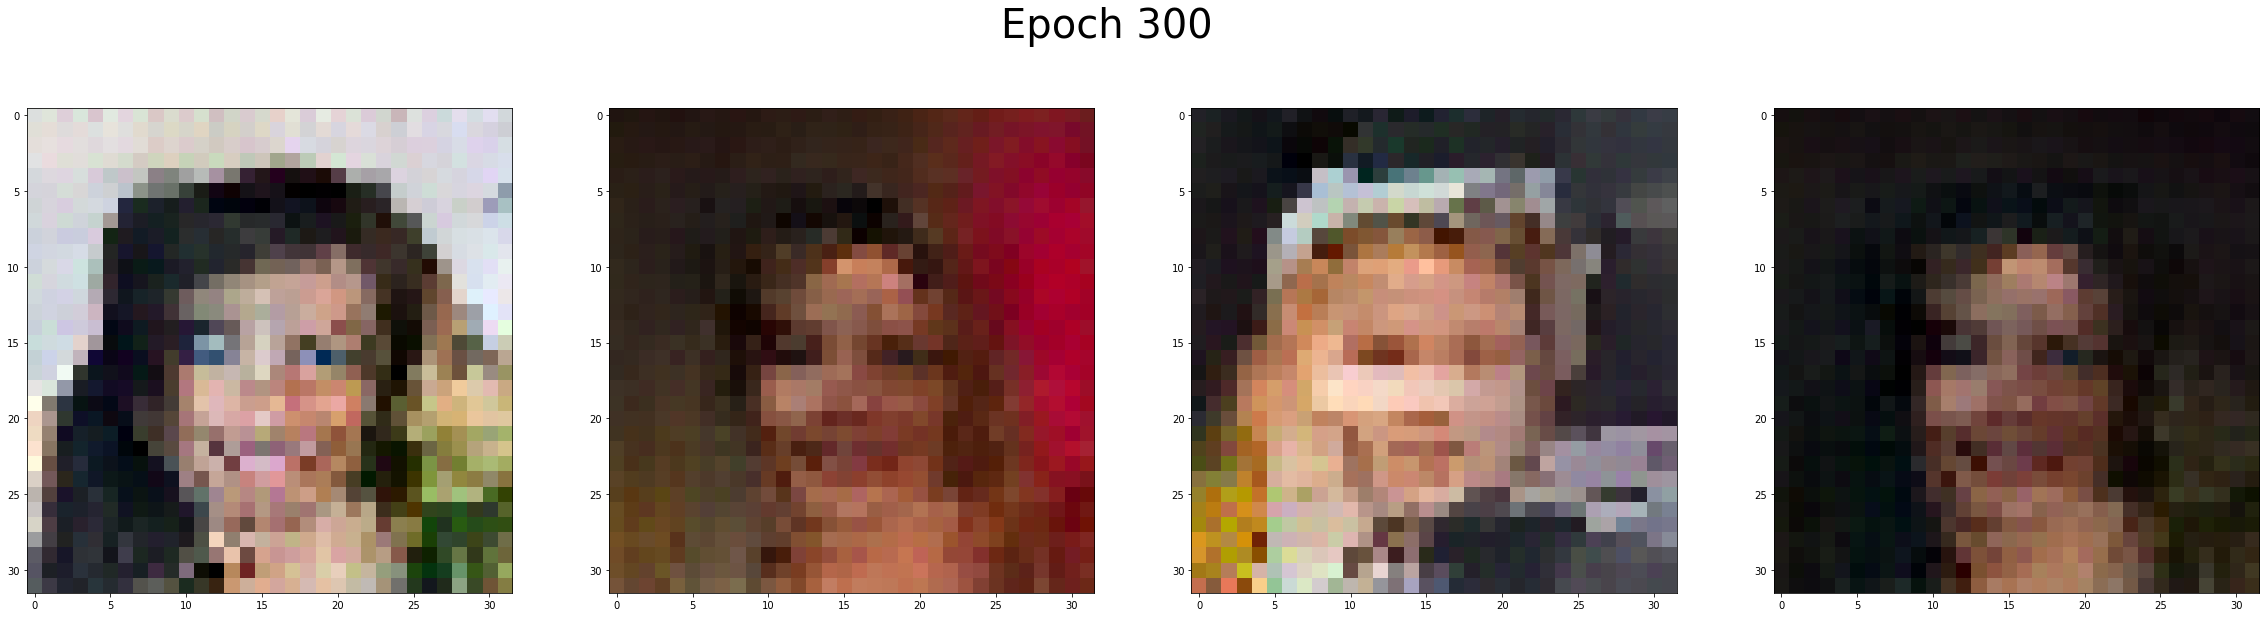

In [ ]:
plot_images(sample_z, title="Epoch {}".format(300))

## Plot D-Loss, G-Loss

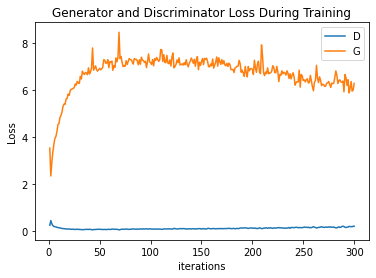

In [ ]:
epochs = range(1,301)

plt.plot(epochs, d_loss_history)    
plt.plot(epochs, g_loss_history)
plt.title('Generator and Discriminator Loss During Training')
plt.legend(['D', 'G'])
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.show()

## G-Loss

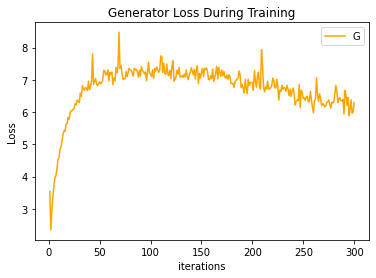

In [ ]:
epochs = range(1,301)

plt.plot(epochs, g_loss_history, 'orange')
plt.title('Generator Loss During Training')
plt.legend(['G'])
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.show()

## D-Loss

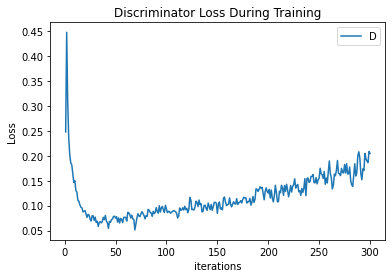

In [ ]:
epochs = range(1,301)

plt.plot(epochs, d_loss_history)
plt.title('Discriminator Loss During Training')
plt.legend(['D'])
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.show()